In [1]:
%matplotlib inline

from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Pandas Options
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 100)

#Set Seaborn Theme
sns.set_style('darkgrid')

# Used ACS Tables

In [2]:
query = """
SELECT table_id, row_count FROM `fccdsicapstone-218522.broadband.__TABLES__` WHERE table_id IN ('census_block',
'fcc_demography', 'tiger_acs_2016_raw', 'laws_against_municipal_broadband') 
"""
tables = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

tables.sort_values('row_count', ascending=False)

,table_id,row_count
1,fcc_demography,11166336
0,census_block,11007989
3,tiger_acs_2016_raw,216330
2,laws_against_municipal_broadband,49


# census_block, left join fcc and acs attributes

In [3]:
query = """
WITH block_level AS (
  SELECT 
    SUBSTR(block.block_code, 0, 12) AS block_group
    , CASE WHEN fcc.block_code IS NULL THEN 0 ELSE 1 END AS int_avail
  FROM broadband.census_block block
  LEFT JOIN (SELECT DISTINCT block_code FROM broadband.fcc WHERE file_date = 201706 AND max_down > 4.0 AND max_up > 1.0) fcc
    ON block.block_code = fcc.block_code
  LEFT JOIN broadband.fcc_demography
    ON block.block_code = fcc_demography.block_code
  WHERE fcc_demography.population_2016 > 0 AND fcc_demography.housing_unit_2016 > 0
),

block_group_level AS ( 
  SELECT 
    block_group
    , AVG(int_avail) AS int_avail_per_2017
  FROM block_level
  GROUP BY block_group
)

SELECT DISTINCT
  block_group_level.block_group
  , block_group_level.int_avail_per_2017
  , SAFE_DIVIDE(data.road_length, data.land_area) AS road_density
  , data.elev_mean
  , data.elev_range
  , data.winter_temp AS winter_temperature
  , SAFE_DIVIDE(data.population, data.land_area) AS population_density
  , data.male_rate
  , data.median_income
  , data.median_age
  , data.white_rate
  , data.avg_years_of_edu
  , data.unemployment_rate
  , SAFE_DIVIDE(data.housing_units, data.land_area) AS housing_density
  , data.house_owner_rate
  , data.newly_moved_household_rate
  , data.newly_built_housing_rate
  , law.laws_against
  --, IFNULL(law.type, 'no_law') AS law_type
FROM block_group_level
LEFT JOIN broadband.tiger_acs_2016 AS data
  ON block_group_level.block_group = data.block_group
LEFT JOIN broadband.laws_against_municipal_broadband law
  ON SUBSTR(block_group_level.block_group, 0, 2) = law.state_code
"""

all_data = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

In [4]:
all_data.shape

(215527, 18)

### Data clean up

In [5]:
all_data.count() / all_data.shape[0] * 100

block_group                   100.000000
int_avail_per_2017            100.000000
road_density                   99.966594
elev_mean                      99.968449
elev_range                     99.968449
winter_temperature             99.940147
population_density             99.966594
male_rate                      99.808377
median_income                  97.294539
median_age                     99.778682
white_rate                     99.808377
avg_years_of_edu               99.808377
unemployment_rate              99.725788
housing_density                99.966594
house_owner_rate               99.672895
newly_moved_household_rate     99.672895
newly_built_housing_rate       99.692382
laws_against                  100.000000
dtype: float64

In [6]:
data = all_data.dropna()

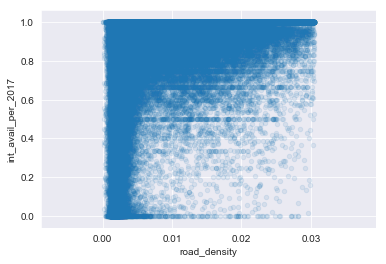

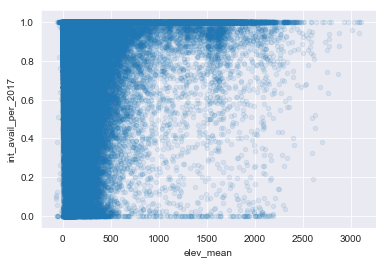

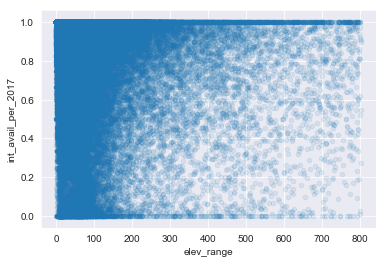

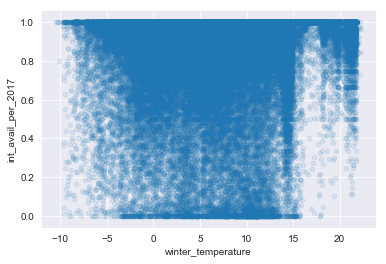

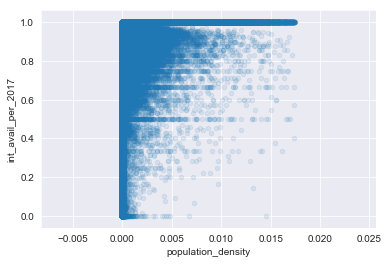

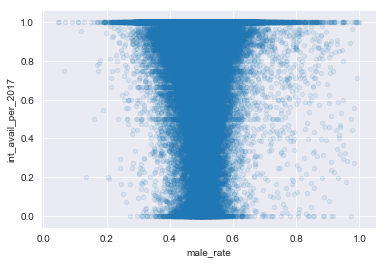

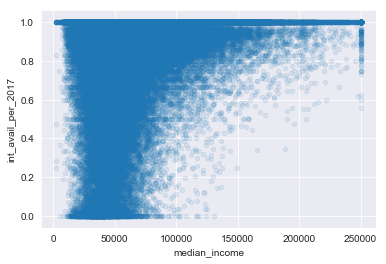

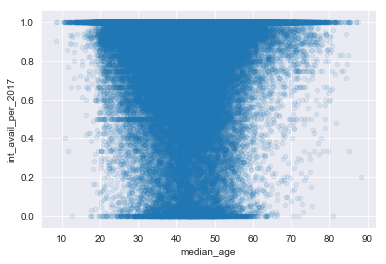

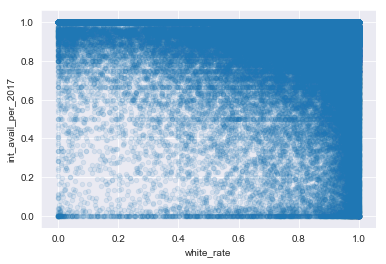

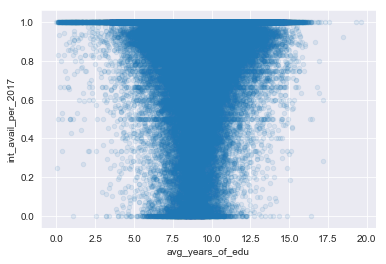

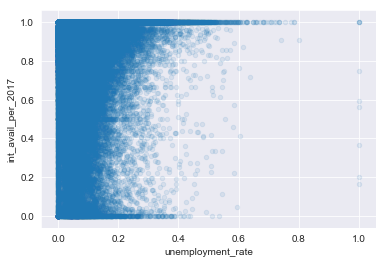

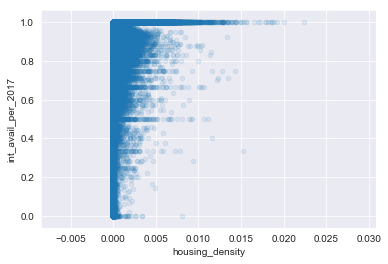

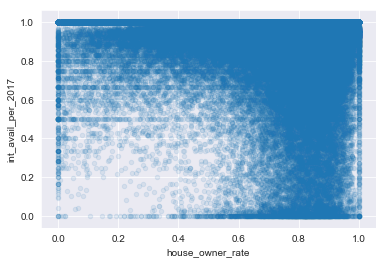

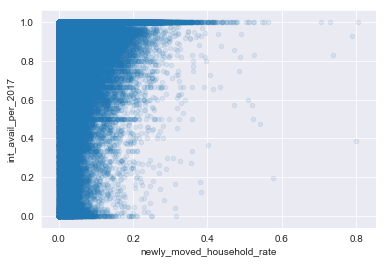

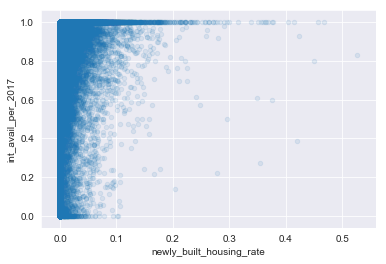

In [7]:
mask = ((data.elev_range < data.elev_range.quantile(0.99)) &
        (data.road_density < data.road_density.quantile(0.98)) &
        (data.population_density < data.population_density.quantile(0.98)))
viz = data[mask]
viz.reset_index(inplace=True)

for col in viz.select_dtypes(include=[np.float]).columns[1:]:
    viz.plot(x=col, y='int_avail_per_2017', kind='scatter', alpha=0.1)

Text(0.5,0,'Internet availability percentage')

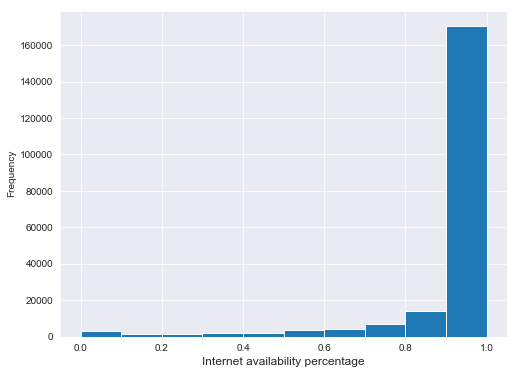

In [8]:
ax = data.int_avail_per_2017.plot(kind='hist', figsize=(8, 6))
ax.set_xlabel('Internet availability percentage', fontsize=12)

In [9]:
data.int_avail_per_2017.describe()

count    209627.000000
mean          0.923336
std           0.184868
min           0.000000
25%           0.950000
50%           1.000000
75%           1.000000
max           1.000000
Name: int_avail_per_2017, dtype: float64

In [10]:
full_coverage = (data.int_avail_per_2017 == 1).sum() / data.shape[0] * 100
print('block_group with full coverage', full_coverage)
print('block_group without full coverage', 100 - full_coverage)

block_group with full coverage 69.28830732682336
block_group without full coverage 30.711692673176643


# Correlation Analysis

Removing ethnicity & NA

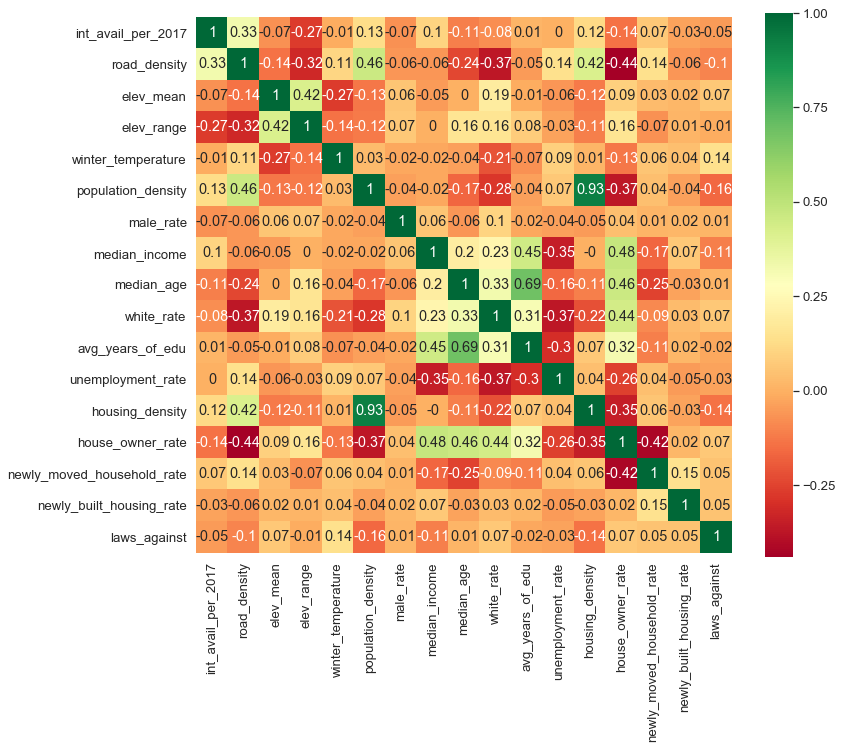

In [11]:
corr = data.corr().round(2)

sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, ax=ax, cmap='RdYlGn', square=True, annot=True)
plt.show()

# Building a classification model.

In [12]:
pd.options.mode.chained_assignment = None
data['is_full_coverage'] = (data['int_avail_per_2017'] == 1)

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

target_col = 'is_full_coverage'
X = data.drop(columns=['int_avail_per_2017', 'block_group', target_col])
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

rfc = RandomForestClassifier(max_depth=60, min_samples_split=8, n_estimators=10, class_weight='balanced')
rfc.fit(X_train, y_train)

print('Train Score:', rfc.score(X_train, y_train))
print('Test Score:', rfc.score(X_test, y_test))

params = {
    'min_samples_split': np.linspace(2, 6, 3, dtype = int),
    'max_depth': np.linspace(20, 50, 4, dtype = int),
}

grid_search = GridSearchCV(estimator=rfc, param_grid=params, scoring='f1', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Grid Searched Train Score:', grid_search.score(X_train, y_train))
print('Grid Searched Test Score:', grid_search.score(X_test, y_test))
print('Best Parameters:', grid_search.best_params_)

Train Score: 0.9669590521225276
Test Score: 0.7860277632018318
Grid Searched Train Score: 0.9819604807671634
Grid Searched Test Score: 0.8505448797936944
Best Parameters: {'max_depth': 30, 'min_samples_split': 6}


In [14]:
y_pred_balanced_test = grid_search.predict(X_test)
confusion_matrix = pd.crosstab(y_test, y_pred_balanced_test, rownames=['Actual'], colnames=['Predicted'])

confusion_matrix

Predicted,False,True
Actual,,
False,7382,5494
True,3489,25561


# Find outliers

In [15]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination='auto', behaviour='new')
data['outlier'] = iso.fit_predict(X, y)

out = data[['block_group', 'int_avail_per_2017', 'outlier']]
outliers = out[(data.int_avail_per_2017 < 0.5) & (data.outlier == -1)]

outliers.sort_values('int_avail_per_2017')

,block_group,int_avail_per_2017,outlier
137681,261614022002,0.000000,-1
184108,350439409002,0.000000,-1
213073,040059422023,0.000000,-1
161418,040059422011,0.000000,-1
209915,350459432013,0.000000,-1
213006,410059800001,0.000000,-1
212751,040050021001,0.000000,-1
183997,011190115003,0.000000,-1
161421,490099601001,0.000000,-1
163449,060650456052,0.000000,-1


# Finding important features.

In [16]:
coefficients = pd.DataFrame(list(zip(X.columns, grid_search.best_estimator_.feature_importances_))
                            , columns=['feature', 'gini_coef'])
coefficients.sort_values('gini_coef', ascending=False)

,feature,gini_coef
4,population_density,0.173966
3,winter_temperature,0.109396
11,housing_density,0.108410
2,elev_range,0.084719
1,elev_mean,0.080564
0,road_density,0.068670
8,white_rate,0.052877
6,median_income,0.048575
12,house_owner_rate,0.045334
9,avg_years_of_edu,0.043873


# Predicting the areas that is most likely to have full coverage

In [17]:
no_full_coverage = data[~data.is_full_coverage].copy()

X_pred = no_full_coverage.drop(columns=['int_avail_per_2017', 'block_group', 'outlier', target_col])
proba = grid_search.predict_proba(X_pred)
no_full_coverage['proba'] = proba[:, 1]

### Among the blocks that do not currently have coverage (less than 50% coverage), what are the blocks that are likely to have coverage?

In [18]:
no_coverage = no_full_coverage[no_full_coverage.int_avail_per_2017 < 0.5]
no_coverage.sort_values('proba', ascending=False)[['block_group', 'proba', 'int_avail_per_2017']].head(10)

,block_group,proba,int_avail_per_2017
73923,060590753011,1.000000,0.357143
59826,180816113004,0.974362,0.250000
68188,390950047021,0.957077,0.363636
55589,060730202114,0.939935,0.000000
94135,080410065012,0.930712,0.400000
26618,060730157011,0.930712,0.285714
36476,340130109002,0.930712,0.333333
115231,191390508002,0.930712,0.222222
207388,060710074044,0.924994,0.416667
112544,181650205005,0.924949,0.210526
